### <b><font color='blue'>2.1 Imports</font></b>

In [1]:
# Built-in
import os, warnings, gc, joblib

# Data
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#metrics
from sklearn.metrics import accuracy_score,auc,f1_score

# feature selection
from sklearn.feature_selection import VarianceThreshold

#feature sampling
from imblearn.over_sampling import SMOTENC

In [2]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option("expand_frame_repr", False)

In [328]:
########################

def re_discretize(discrete_values, values_to_discretize):
    """ This function is useful for re-discretizing the values of
    synthetic individuals after SMOTE in any numerical variable that
    is originally discrete.
    It rounds the values in the array values_to_discretize to the
    closest value in the array discrete_values (which represents the
    truly existing values of the discrete variable)

    Parameters
    ----------
    discrete_values : Array-like
        Original discrete values, sorted in ascending/descending order
    values_to_discretize : Array-like
        Values to be discretized

    Returns
    -------
    np.ndarray
        Same shape as values_to_discretize, rounded to the
        nearest value found in discrete_values
    """
    # The function searchsorted identifies for every value in
    # values_to_discretize the index that should be used if inserting
    # values, to maintain an ordered array
    insertion_index = np.searchsorted(discrete_values, values_to_discretize)

    # We use this index to get the closest lower index and the closest upper
    # index
    index_closest_lower = (insertion_index).clip(min=0)
    index_closest_upper = insertion_index.clip(max=len(discrete_values) - 1)

    # We use these indexes to compute the distances between a value in
    # values_to_discretize and its closest values (lower and upper) in
    # discrete_values
    closest_indexes = np.vstack((index_closest_lower, index_closest_upper))
    closest_values = np.take(discrete_values, closest_indexes)
    shortest_distances = abs(closest_values[0] - np.vstack((values_to_discretize,values_to_discretize)))

    # We then use the value that is the nearest between these lower
    # and upper bounds
    nearest_value = shortest_distances.argmin(axis=0)
    discretized_values = closest_values[
        nearest_value, np.arange(len(values_to_discretize))
    ]

    return discretized_values

### <a name="C22"><font color='blue'>2.2 Import DataFrames & Feature Engennering</font></a> 

In [5]:
def train_application():
    # Preprocess application_train.csv and application_test.csv
    df = pd.read_csv('data/source/application_train.csv',index_col='SK_ID_CURR')
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Only keep columns with less than 20% missing values.
    colnoNas = joblib.load('data/cleaned/list_col_to_keep_from_train_application.joblib')
    df = df[colnoNas]
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    for x in ['FONDKAPREMONT_MODE','HOUSETYPE_MODE','NAME_TYPE_SUITE','OCCUPATION_TYPE','ORGANIZATION_TYPE']: 
        df[x].loc[df[x].isna()]='XNA'

    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category = False)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # revenu par enfant
    df['INCOME_PER_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (df['CNT_CHILDREN']+1)

    # ratio d'enfant
    df['CHIDREN_RATE'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']

    # ratio defaillance
    #df['DEF_30_RATE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'] / df['OBS_30_CNT_SOCIAL_CIRCLE']
    #df['DEF_60_RATE'] = df['DEF_60_CNT_SOCIAL_CIRCLE'] / df['OBS_60_CNT_SOCIAL_CIRCLE']

    gc.collect()
    return df

In [6]:
df = train_application().reset_index()
print(df.shape)
df.head()

(307507, 80)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FONDKAPREMONT_MODE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,INCOME_PER_CHILDREN,CHIDREN_RATE
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,reg oper account,block of flats,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749,202500.0,0.0
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,0,0,0,0,0,0,School,0.622246,NaN,reg oper account,block of flats,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598,270000.0,0.0
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,0,0,0,0,0,0,Government,0.555912,0.729567,XNA,XNA,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000,67500.0,0.0
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,XNA,XNA,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941,135000.0,0.0
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,0,0,0,0,1,1,Religion,0.322738,NaN,XNA,XNA,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623,121500.0,0.0


In [8]:
import time
from contextlib import contextmanager
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

    # One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

############################################################################################################################
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/source/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/source/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

############################################################################################################################
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/source/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

############################################################################################################################
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/source/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

############################################################################################################################
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/source/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

############################################################################################################################
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/source/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


### Merge all data

In [9]:
num_rows = None
# Only keep columns with less than 20% missing values.
bestfeatures = joblib.load('data/cleaned/list_best_features.joblib')


with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    #bureau = bureau[[x for x in bureau.columns if x in bestfeatures]]
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    #prev = prev[[x for x in prev.columns if x in bestfeatures]]
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    #pos = pos[[x for x in pos.columns if x in bestfeatures]]
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    #ins = ins[[x for x in ins.columns if x in bestfeatures]]
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
#with timer("Process credit card balance"):
#    cc = credit_card_balance(num_rows)
#    print("Credit card balance df shape:", cc.shape)
#    df = df.join(cc, how='left', on='SK_ID_CURR')
#    del cc
#    gc.collect()

Bureau df shape: (305811, 18)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 61)
Process previous_applications - done in 24s
Pos-cash balance df shape: (337252, 8)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 13)
Process installments payments - done in 25s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 76984 to 133862
Columns: 180 entries, SK_ID_CURR to INSTAL_DAYS_ENTRY_PAYMENT_MEAN
dtypes: float64(128), int64(42), object(10)
memory usage: 27.6+ MB


### Vriables discretes / variables categorielles / variables numeriques

#### variables discretes

In [51]:
var_discretes = df.nunique()[df.nunique()<25].index.tolist()
var_discretes.remove('TARGET')
var_discretes = [ var for var in var_discretes if var in df.select_dtypes(exclude=object).columns]
var_discretes.remove('CHIDREN_RATE')
var_discretes = [var_discretes[i] for i,x in enumerate((df[var_discretes].apply(lambda x: x%1!=0.0).sum()==0).values) if x]

df.loc[:,var_discretes].apply(lambda x: x.unique())

CODE_GENDER                                                               [1, 0]
FLAG_OWN_CAR                                                              [0, 1]
FLAG_OWN_REALTY                                                           [1, 0]
CNT_CHILDREN                                    [0, 1, 2, 3, 5, 4, 7, 6, 19, 12]
FLAG_MOBIL                                                                [1, 0]
FLAG_EMP_PHONE                                                            [0, 1]
FLAG_WORK_PHONE                                                           [0, 1]
FLAG_CONT_MOBILE                                                          [1, 0]
FLAG_PHONE                                                                [0, 1]
FLAG_EMAIL                                                                [0, 1]
CNT_FAM_MEMBERS                [1.0, 3.0, 2.0, 4.0, 5.0, 7.0, 6.0, 8.0, 20.0,...
REGION_RATING_CLIENT                                                   [2, 3, 1]
REGION_RATING_CLIENT_W_CITY 

In [12]:
var_discretes

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

#### variables categotielles

In [89]:
print( df.select_dtypes(include=object).nunique() )
var_cat = df.select_dtypes(include=object).nunique().index.tolist()

NAME_CONTRACT_TYPE      2
NAME_TYPE_SUITE         8
NAME_INCOME_TYPE        6
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      5
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        19
ORGANIZATION_TYPE      57
FONDKAPREMONT_MODE      5
HOUSETYPE_MODE          4
dtype: int64


In [14]:
var_cat

['NAME_CONTRACT_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE']

In [15]:
df.loc[:,var_cat].apply(lambda x: np.unique(x) ) 

NAME_CONTRACT_TYPE                         [Cash loans, Revolving loans]
NAME_TYPE_SUITE        [Children, Family, Group of people, Other_A, O...
NAME_INCOME_TYPE       [Businessman, Commercial associate, Pensioner,...
NAME_EDUCATION_TYPE    [Academic degree, Higher education, Incomplete...
NAME_FAMILY_STATUS     [Civil marriage, Married, Separated, Single / ...
NAME_HOUSING_TYPE      [Co-op apartment, House / apartment, Municipal...
OCCUPATION_TYPE        [Accountants, Cleaning staff, Cooking staff, C...
ORGANIZATION_TYPE      [Advertising, Agriculture, Bank, Business Enti...
FONDKAPREMONT_MODE     [XNA, not specified, org spec account, reg ope...
HOUSETYPE_MODE         [XNA, block of flats, specific housing, terrac...
dtype: object

#### variables numériques

In [408]:
var_num = [x for x in df.columns if x not in var_cat and x not in var_discretes]
var_num.remove('SK_ID_CURR') 
var_num.remove('TARGET')
#var_num.append( 'CHIDREN_RATE' )
df.loc[:,var_num].apply(lambda x: x.iloc[[5,1000]] )

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,INCOME_PER_CHILDREN,CHIDREN_RATE,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,APPROVED_AMT_ANNUITY_MEAN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MEAN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN
108169,112500.0,916470.0,32598.0,765000.0,0.010643,-15696,-547.0,-878.0,-2109,0.497886,0.129314,4.0,0.0,4.0,0.0,-435.0,0.0,0.0,0.0,0.0,0.0,3.0,0.034850,0.122754,37500.0,0.289760,0.035569,56250.0,0.333333,-245.0,-396.500,1339.0,888.750000,0.0,0.0,765000.0,425113.875,1700455.5,533458.755,272216.68875,1088866.755,0.0,231541.245,0.000,0.0,0.0,0.0,

In [388]:
var_num

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'INCOME_PER_CHILDREN',
 'CHIDREN_RATE',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'BURO_AMT_

### <a name="C3"><font color='teal'>3 Create X & y</font></a> 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer

# Charger les données
#data = df.copy()

df = df.loc[df.apply(lambda x: (x==np.inf)).sum(axis=1)==0]
#df = df.loc[df.apply(lambda x: (x==np.nan)).sum(axis=1)==0]

# Séparer les variables indépendantes (X) de la variable cible (y)
#X = df.dropna().drop('TARGET', axis=1)
#y = df.dropna()['TARGET']

# Séparer les données en train_data et test_data
train_data, test_data, train_target, test_target = train_test_split(df.drop(['TARGET','SK_ID_CURR'], axis=1), 
                                                                    df['TARGET'], 
                                                                    test_size=0.2, random_state=42)

# Recuperer les noms des colonnes
colNames = df.drop(['TARGET','SK_ID_CURR'], axis=1).columns

In [19]:
df.shape

(19999, 180)

In [20]:
print(train_data.shape, test_data.shape)

(15999, 178) (4000, 178)


#### Obtenir les indices des types de colonnes

In [21]:
# Indices des variables catégorielles
cat_indices = [i for i,x in enumerate(df.drop(['TARGET','SK_ID_CURR'], axis=1).columns) if x in var_cat]  
# Exemple : les colonnes 0, 2 et 4 sont les variables catégorielles

# Indices des variables numériques discrètes
discrete_num_indices = [i for i,x in enumerate(df.drop(['TARGET','SK_ID_CURR'], axis=1).columns) if x in var_discretes]  
# Exemple : les colonnes 1 et 3 sont les variables numériques discrètes

# Indices des variables numériques continues
continuous_num_indices = [i for i,x in enumerate(df.drop(['TARGET','SK_ID_CURR'], axis=1).columns) if x in var_num]  
# Exemple : les colonnes 1 et 3 sont les variables numériques discrètes

all_num_indices = discrete_num_indices + continuous_num_indices

#del X,y
gc.collect()

0

#### Imputer les valeurs manquantes

In [22]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [23]:
# Créer les transformers pour les variables catégorielles et numériques
cat_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
num_transformer = StandardScaler()

# Créer le ColumnTransformer pour appliquer les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_indices),
        ('num', num_transformer, all_num_indices)
    ])

# Créer un imputeur pour remplacer les valeurs manquantes 
imputer = IterativeImputer(random_state=0)

# Créer le pipeline avec le préprocesseur et le classifieur
pipeImputer = Pipeline([
    ('preprocessor', preprocessor),
    ('iterimputer', imputer),
])

# Entraîner le pipeline sur les données d'entraînement
pipeImputer.fit(train_data, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 9, 10, 11, 12, 13, 25, 35,
                                                   38, 39]),
                                                 ('num', StandardScaler(),
                                                  [1, 2, 3, 4, 19, 20, 21, 22,
                                                   23, 24, 26, 27, 28, 29, 30,
                                                   31, 32, 33, 34, 45, 46, 47,
                                                   48, 49, 50, 51, 52, 53, 54,
                                                   55, ...])])),
                ('iterimputer', IterativeImputer(random_state=0))])

In [24]:
train_data_imputed = pipeImputer.transform(train_data)
train_data_imputed = pd.DataFrame(train_data_imputed,
                                  columns=pipeImputer.get_feature_names_out())

#### Transformation Inverse oneHotencoder

In [25]:
# obtenir l'encoder à partir du pipe
ohe = pipeImputer['preprocessor'].transformers_[0][1]

# Conversion inverse_transform
train_data_cat = ohe.inverse_transform(train_data_imputed.filter(regex='^cat_'))

# pd.Dataframe
train_data_cat = pd.DataFrame( train_data_cat, columns=ohe.feature_names_in_)

#### Transformation Inverse Standard Scaler

In [29]:
# obtenir l'encoder à partir du pipe
sc = pipeImputer['preprocessor'].transformers_[1][1]

# Conversion inverse_transform
#train_data_num = sc.inverse_transform(train_data_imputed.filter(regex='^num_'))

# pd.Dataframe numerique features
#train_data_num = pd.DataFrame( train_data_num, columns=sc.feature_names_in_)
train_data_num = train_data_imputed.filter(regex='^num_')
train_data_num.columns = [x.replace('num__','') for x in train_data_num.columns]

#### Reformation du dataframe 

In [30]:
train_data_imputed_TI = pd.concat([train_data_cat, train_data_num], axis = 1 )
del train_data_cat, train_data_num
gc.collect()

480

In [31]:
print(train_data_imputed_TI.shape,train_data.shape)

(15999, 178) (15999, 178)


In [32]:
[x for x in train_data.columns if x not in train_data_imputed_TI]

[]

In [33]:
df.shape

(19999, 180)

#### Obtenir les indices des types de colonnes

In [92]:
# Indices des variables catégorielles
cat_indices = [i for i,x in enumerate(train_data_imputed_TI.columns) if x in var_cat]  
# Exemple : les colonnes 0, 2 et 4 sont les variables catégorielles

# Indices des variables numériques discrètes
discrete_num_indices = [i for i,x in enumerate(train_data_imputed_TI.columns) if x in var_discretes]  
# Exemple : les colonnes 1 et 3 sont les variables numériques discrètes

# Indices des variables numériques continues
continuous_num_indices = [i for i,x in enumerate(train_data_imputed_TI.columns) if x in var_num]  
# Exemple : les colonnes 1 et 3 sont les variables numériques discrètes

all_num_indices = discrete_num_indices + continuous_num_indices

colNames = colNames[cat_indices +discrete_num_indices+ continuous_num_indices]
#del X,y
gc.collect()

2170

#### Scale des features numériques

#### Concaténation des features

In [36]:
pd.DataFrame(np.c_[train_target.value_counts(),
                   train_target.value_counts(normalize = True)],
             columns=['Raw','Normalized'])

,Raw,Normalized
0,14699.0,0.918745
1,1300.0,0.081255


#### Over-Sampling data

In [329]:
%%time
# Créer l'instance SMOTENC
smotenc = SMOTENC(sampling_strategy=0.5, categorical_features= cat_indices , random_state=97)
train_data_res, train_target_res = smotenc.fit_resample(train_data_imputed_TI, train_target)

CPU times: total: 35.2 s
Wall time: 11.9 s


In [94]:
train_data_res.shape

(22048, 178)

In [95]:
train_target_res.shape

(22048,)

In [96]:
pd.DataFrame(np.c_[train_target_res.value_counts(),
                   train_target_res.value_counts(normalize = True)],
             columns=['Raw','Normalized'])

,Raw,Normalized
0,14699.0,0.666682
1,7349.0,0.333318


#### Re-traiter les variables numériques DISCRETES

Une variable discrète est une variable prenant un faible nombre de valeurs fixes, </br>
par exemple le nombre de contrats d’un client, ou l’âge arrondi à l’année. </br>
Pour ces variables le SMOTE conduit à un pattern particulier, illustré par l’histogramme suivant :</br>
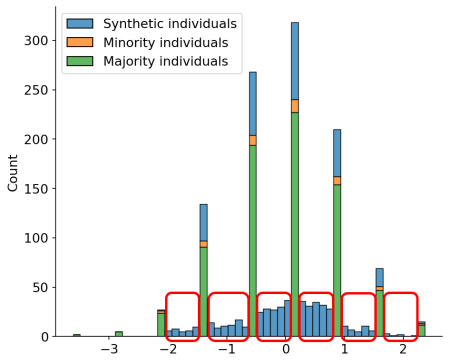 </br>

En présence d’une variable discrète, le SMOTE crée des individus synthétiques dans des régions où aucun individu réel ne se trouve. Nommons ces régions les “zones synthétiques irréelles”. Elles correspondent aux encadrés rouges dans la figure ci-dessus.

Dans ces zones synthétiques irréelles, le signal est pur : elles contiennent uniquement des individus positifs. Un modèle avec une bonne capacité de séparation de l’espace comme un algorithme par arbre (tree-based learner) ou un réseau de neurones profond (deep neural network) va donc concentrer une partie des ses efforts d’apprentissage sur ces régions. En effet, s’il isole parfaitement une zone synthétique irréelle, il prédira une probabilité de 1 dans cette zone et fera donc une prédiction correcte à 100%. Il augmentera ainsi sa performance sur les données Train.

Plusieurs points sont à noter :

* Ces régions ne seront jamais rencontrées dans les données de validation/test : elles sont donc “apprises pour rien” et n’impactent pas la performance du modèle mesurée sur validation/test (tant que vous ne faites pas l’erreur de faire du SMOTE sur ces données).
</br>
* Mais elles génèrent une forte variance (écart de performance entre les données Train et Validation/Test) et sont susceptibles de déformer le signal appris par le modèle, qui devient alors moins robuste et moins interprétable.
</br>
* Enfin elles rallongent le temps d’apprentissage du modèle, qui dépense du temps à apprendre ces régions inutiles.

#### Liste contenant les indices des variables numériques discrètes

In [97]:
[x for x in train_data_imputed_TI.iloc[:,continuous_num_indices].columns if x not in var_num]

[]

In [98]:
# Indices des variables catégorielles
cat_indices = [i for i,x in enumerate(train_data_imputed_TI.columns) if x in var_cat]  

# Indices des variables numériques discrètes
discrete_num_indices = [i for i,x in enumerate(train_data_imputed_TI.columns) if x in var_discretes]  

# Indices des variables numériques continues
continuous_num_indices = [i for i,x in enumerate(train_data_imputed_TI.columns) if x in var_num]  

#### Retraiter les variables numériques discrètes avec la fonction re_discretize

In [330]:
for numeric_discrete_col in discrete_num_indices:
    train_data_res.iloc[:, numeric_discrete_col] = re_discretize(
        np.unique(train_data_imputed_TI.iloc[:, numeric_discrete_col]),
        train_data_res.iloc[:, numeric_discrete_col],
    )

In [331]:
train_data[var_discretes].apply(lambda x: x.nunique())

CODE_GENDER                     2
FLAG_OWN_CAR                    2
FLAG_OWN_REALTY                 2
CNT_CHILDREN                   10
FLAG_MOBIL                      2
FLAG_EMP_PHONE                  2
FLAG_WORK_PHONE                 2
FLAG_CONT_MOBILE                2
FLAG_PHONE                      2
FLAG_EMAIL                      2
CNT_FAM_MEMBERS                10
REGION_RATING_CLIENT            3
REGION_RATING_CLIENT_W_CITY     3
REG_REGION_NOT_LIVE_REGION      2
REG_REGION_NOT_WORK_REGION      2
LIVE_REGION_NOT_WORK_REGION     2
REG_CITY_NOT_LIVE_CITY          2
REG_CITY_NOT_WORK_CITY          2
LIVE_CITY_NOT_WORK_CITY         2
FLAG_DOCUMENT_2                 2
FLAG_DOCUMENT_3                 2
FLAG_DOCUMENT_4                 2
FLAG_DOCUMENT_5                 2
FLAG_DOCUMENT_6                 2
FLAG_DOCUMENT_7                 2
FLAG_DOCUMENT_8                 2
FLAG_DOCUMENT_9                 2
FLAG_DOCUMENT_10                1
FLAG_DOCUMENT_11                2
FLAG_DOCUMENT_

In [332]:
train_data_res[var_discretes].apply(lambda x: x.nunique())

CODE_GENDER                     2
FLAG_OWN_CAR                    2
FLAG_OWN_REALTY                 2
CNT_CHILDREN                   10
FLAG_MOBIL                      2
FLAG_EMP_PHONE                  2
FLAG_WORK_PHONE                 2
FLAG_CONT_MOBILE                2
FLAG_PHONE                      2
FLAG_EMAIL                      2
CNT_FAM_MEMBERS                10
REGION_RATING_CLIENT            3
REGION_RATING_CLIENT_W_CITY     3
REG_REGION_NOT_LIVE_REGION      2
REG_REGION_NOT_WORK_REGION      2
LIVE_REGION_NOT_WORK_REGION     2
REG_CITY_NOT_LIVE_CITY          2
REG_CITY_NOT_WORK_CITY          2
LIVE_CITY_NOT_WORK_CITY         2
FLAG_DOCUMENT_2                 2
FLAG_DOCUMENT_3                 2
FLAG_DOCUMENT_4                 2
FLAG_DOCUMENT_5                 2
FLAG_DOCUMENT_6                 2
FLAG_DOCUMENT_7                 2
FLAG_DOCUMENT_8                 2
FLAG_DOCUMENT_9                 2
FLAG_DOCUMENT_10                1
FLAG_DOCUMENT_11                2
FLAG_DOCUMENT_

#### Inverse Scaling numeriques features

#### Encoder les données catégorielles

In [409]:
# Créer les transformers pour les variables catégorielles et numériques
#cat_transformer = OneHotEncoder(drop = 'first',sparse=False, handle_unknown='ignore')
#cat_transformer.fit(train_data_res.iloc[:,var_cat])

# Appliquer le one-hot encoding aux variables catégorielles
train_data_encoded = ohe.transform(train_data_res[var_cat])

In [410]:
# Créer un dataframe à partir des variables encodées
train_data_encoded = pd.DataFrame(train_data_encoded, 
                                  columns=ohe.get_feature_names_out())

In [411]:
[x for x in train_data_encoded.columns if x not in [x.replace('cat__','').replace('num__','') for x in test_data_imputed.columns]]

[]

In [412]:
# Ajouter les variables numériques au dataframe encodé
train_data_encoded = pd.concat([train_data_encoded,train_data_res[  var_discretes + var_num ]],axis=1)

In [413]:
train_data_encoded.shape, train_data_res.shape

((22048, 284), (22048, 178))

#### test_data transformation

In [420]:
test_data_imputed = pipeImputer.transform(test_data)
test_data_imputed = pd.DataFrame(test_data_imputed,
                                  columns=[x.replace('cat__','').replace('num__','') for x in pipeImputer.get_feature_names_out()])

In [421]:
train_data_encoded.shape,test_data_imputed.shape

((22048, 284), (4000, 284))

In [422]:
ttt = test_data_imputed.columns
ttt =[x for x in ttt]

In [423]:
[x for x in train_data_encoded.columns if x not in ttt]

[]

In [424]:
[x for x in ttt  if x not in train_data_encoded.columns]

[]

#### Creation et comparaison de model

In [345]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMRegressor

In [428]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
def generate_auc_roc_curve(clf, X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label = clf.__class__.__name__+': AUC ='+str(auc))
    plt.legend(loc=4)
    pass

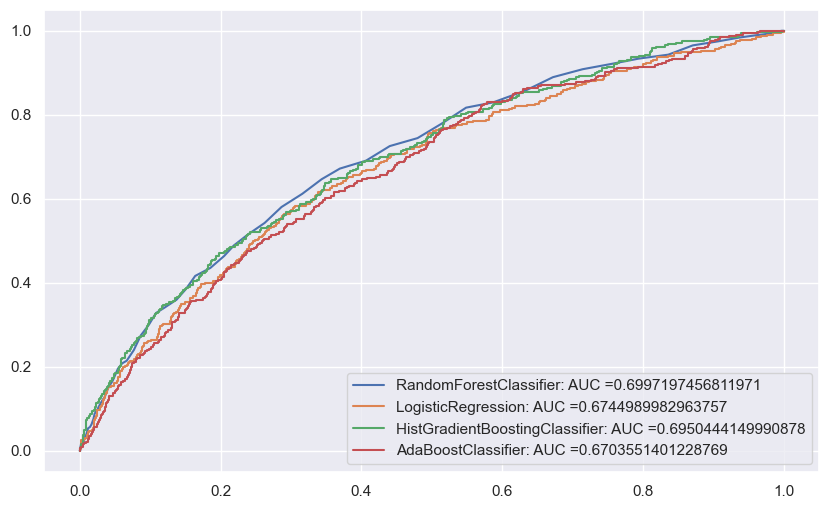

In [431]:
rfc = RandomForestClassifier().fit(train_data_encoded,train_target_res)
logr = LogisticRegression().fit(train_data_encoded,train_target_res)
HistGB = HistGradientBoostingClassifier().fit(train_data_encoded,train_target_res)
adac = AdaBoostClassifier().fit(train_data_encoded,train_target_res)

generate_auc_roc_curve(rfc, test_data_imputed,test_target)
generate_auc_roc_curve(logr, test_data_imputed,test_target)
generate_auc_roc_curve(HistGB, test_data_imputed,test_target)
generate_auc_roc_curve(adac, test_data_imputed,test_target)

In [437]:
def convertMillis(millis):
    millis = int(millis)
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    hours=(millis/(1000*60*60))%24
    return "%dh : %dmin : %ds : %dms" % (hours, minutes, seconds,millis)

In [439]:
from sklearn.model_selection import cross_validate
def compute_clf_cross_validate_score_time(clf, X, y):
    # get starting time
    start = time.time()
    #y = y.astype('object')
    # compute roc_auc & accuracy score
    xval = cross_validate(clf, X, y, cv = 5,scoring=['roc_auc','roc_auc_ovr_weighted'])
    # get the execution time
    elapsed_time_lc=(time.time()-start)
    
    # Obtient le nom du classifieur
    classifier_name = clf.__class__.__name__
    print("Nom du classifieur:", classifier_name, '. Temps d\'execution :',convertMillis(elapsed_time_lc*1000) )
    
    return {'Time':elapsed_time_lc,
            'AUC mean score':round(np.mean(xval['test_roc_auc']),5),
            'AUC weighted mean score':round(np.mean(xval['test_roc_auc_ovr_weighted']),5),
           }

In [446]:
def result_compute_model(X_train_scaled,y_train):
    res_model_type = dict()

    res_model_type['LogisticRegression'] = compute_clf_cross_validate_score_time(LogisticRegression(), X_train_scaled,y_train)
    res_model_type['LogRegression_balanced'] = compute_clf_cross_validate_score_time(LogisticRegression(class_weight='balanced'), X_train_scaled,y_train)
    res_model_type['RandomForest'] = compute_clf_cross_validate_score_time(RandomForestClassifier(n_estimators = 100), X_train_scaled,y_train)
    res_model_type['AdaBoost'] = compute_clf_cross_validate_score_time(AdaBoostClassifier(n_estimators = 100), X_train_scaled, y_train)
    res_model_type['HistGradientBoosting'] = compute_clf_cross_validate_score_time(HistGradientBoostingClassifier(), X_train_scaled, y_train)
    #res_model_type['LightGBM'] = compute_clf_cross_validate_score_time(LGBMRegressor(), X_train_scaled, y_train)
    
    return res_model_type

In [447]:
%%time
result = result_compute_model(train_data_encoded,train_target_res)

Nom du classifieur: LogisticRegression . Temps d'execution : 0h : 0min : 3s : 3507ms
Nom du classifieur: LogisticRegression . Temps d'execution : 0h : 0min : 3s : 3706ms
Nom du classifieur: RandomForestClassifier . Temps d'execution : 4h : 59min : 12s : 17952662ms
Nom du classifieur: AdaBoostClassifier . Temps d'execution : 0h : 2min : 35s : 155613ms
Nom du classifieur: HistGradientBoostingClassifier . Temps d'execution : 0h : 0min : 35s : 35116ms
CPU times: total: 4min 42s
Wall time: 5h 2min 30s


In [450]:
result

{'LogisticRegression': {'Time': 3.507709503173828,
  'AUC mean score': 0.88825,
  'AUC weighted mean score': 0.88825},
 'LogRegression_balanced': {'Time': 3.7066946029663086,
  'AUC mean score': 0.88709,
  'AUC weighted mean score': 0.88709},
 'RandomForest': {'Time': 17952.66239643097,
  'AUC mean score': 0.97109,
  'AUC weighted mean score': 0.97109},
 'AdaBoost': {'Time': 155.613422870636,
  'AUC mean score': 0.92337,
  'AUC weighted mean score': 0.92337},
 'HistGradientBoosting': {'Time': 35.11645746231079,
  'AUC mean score': 0.95093,
  'AUC weighted mean score': 0.95093}}

In [451]:
pd.DataFrame(result).T[['Time','AUC mean score','AUC weighted mean score']]\
.dropna()\
.sort_values(by =['AUC mean score'],ascending = True)\
.style.background_gradient(cmap='coolwarm').set_precision(4)

,Time,AUC mean score,AUC weighted mean score
LogRegression_balanced,3.7067,0.8871,0.8871
LogisticRegression,3.5077,0.8882,0.8882
AdaBoost,155.6134,0.9234,0.9234
HistGradientBoosting,35.1165,0.9509,0.9509
RandomForest,17952.6624,0.9711,0.9711


In [452]:
%whos

Variable                                Type                              Data/Info
-----------------------------------------------------------------------------------
AdaBoostClassifier                      ABCMeta                           <class 'sklearn.ensemble.<...>ting.AdaBoostClassifier'>
BaggingClassifier                       ABCMeta                           <class 'sklearn.ensemble.<...>gging.BaggingClassifier'>
ColumnTransformer                       ABCMeta                           <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
FunctionTransformer                     type                              <class 'sklearn.preproces<...>mer.FunctionTransformer'>
GradientBoostingClassifier              ABCMeta                           <class 'sklearn.ensemble.<...>dientBoostingClassifier'>
HistGB                                  HistGradientBoostingClassifier    HistGradientBoostingClassifier()
HistGradientBoostingClassifier          ABCMeta                           <

test_data_imputed                       DataFrame                               NAME_CONTRACT_TYPE_<...>[4000 rows x 284 columns]
test_target                             Series                            28641     0\n246862    0\<...>ength: 4000, dtype: int64
time                                    module                            <module 'time' (built-in)>
timer                                   function                          <function timer at 0x0000018127E3AD30>
train_application                       function                          <function train_applicati<...>on at 0x0000018127D57A60>
train_data                              DataFrame                                NAME_CONTRACT_TYPE<...>15999 rows x 178 columns]
train_data_encoded                      DataFrame                                NAME_CONTRACT_TYPE<...>22048 rows x 284 columns]
train_data_imputed                      DataFrame                                cat__NAME_CONTRACT<...>15999 rows x 284 columns]
train_